In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime


# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [3]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_test.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [4]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [5]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (67736 samples)
15.0 % of the data for validation (14516 samples)
15.0 % of the data for testing (14516 samples)


## GPU?

In [15]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [16]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

In [17]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [18]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.08773997812984798
Validation loss:  0.07704492523806736
Train accuracy:  74.65897011928664
Validation accuracy:  77.56268944612842


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.07428024774302955
Validation loss:  0.07083111528783118
Train accuracy:  78.36010393291603
Validation accuracy:  79.3951501791127


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.06888085540394608
Validation loss:  0.06628565416396452
Train accuracy:  79.8748080784221
Validation accuracy:  81.10360980986498


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.06351534036587048
Validation loss:  0.06107464263683374
Train accuracy:  81.80583441596788
Validation accuracy:  82.92918159272527


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.05847081876728363
Validation loss:  0.05420281533726249
Train accuracy:  83.25853312861699
Validation accuracy:  84.68586387434554


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.054006208446689435
Validation loss:  0.05216013433387101
Train accuracy:  84.76290303531357
Validation accuracy:  85.54009368972169


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.049707931650202715
Validation loss:  0.049977805728035354
Train accuracy:  86.15802527459549
Validation accuracy:  86.16009920088179


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0450413394983193
Validation loss:  0.04384697865826049
Train accuracy:  87.57676863115626
Validation accuracy:  87.87544778175806


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.04045143705107645
Validation loss:  0.04048697305802207
Train accuracy:  88.98517774890752
Validation accuracy:  88.7847891981262


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0373508163857097
Validation loss:  0.03500999255918196
Train accuracy:  89.96988307546947
Validation accuracy:  90.5965830807385


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.03442850265461983
Validation loss:  0.033282580170041924
Train accuracy:  90.66080075587575
Validation accuracy:  91.02369798842656


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.029829967119295687
Validation loss:  0.0273149708441832
Train accuracy:  92.0943073107358
Validation accuracy:  92.92504822265087


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02755530558595112
Validation loss:  0.03263253890929768
Train accuracy:  92.71879059879532
Validation accuracy:  91.1752548911546


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02456727203920948
Validation loss:  0.021165494843989215
Train accuracy:  93.524861225936
Validation accuracy:  94.55084045191512


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02384673368108368
Validation loss:  0.02847528046341654
Train accuracy:  93.73006968229598
Validation accuracy:  92.27748691099477


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.02189678846523377
Validation loss:  0.025173023000507232
Train accuracy:  94.2910712176686
Validation accuracy:  93.0559382750069


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01988534557582974
Validation loss:  0.017989087724721773
Train accuracy:  94.8299279555923
Validation accuracy:  95.21906861394324


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0195339663183744
Validation loss:  0.017664475549045246
Train accuracy:  94.94950986181647
Validation accuracy:  95.34995866629926


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0169975615895377
Validation loss:  0.0196327705445006
Train accuracy:  95.67585921814101
Validation accuracy:  94.82639845687517


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.015921667599883477
Validation loss:  0.0157312320110425
Train accuracy:  95.84858863824259
Validation accuracy:  96.12152108018738


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.016305952343906825
Validation loss:  0.02217860281926945
Train accuracy:  95.84711231841266
Validation accuracy:  94.50261780104712


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01511297452134257
Validation loss:  0.011492471858891884
Train accuracy:  96.07151293256172
Validation accuracy:  97.25130890052355


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.014157945193469919
Validation loss:  0.022234092111645946
Train accuracy:  96.37858745718673
Validation accuracy:  94.35106089831909


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.013929923320922568
Validation loss:  0.014095839876107182
Train accuracy:  96.40959017361521
Validation accuracy:  96.31441168365942


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.012483290744887365
Validation loss:  0.009597565351045867
Train accuracy:  96.7255226172198
Validation accuracy:  97.71975750895564


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011995571625011782
Validation loss:  0.011218015925080765
Train accuracy:  96.93368371323963
Validation accuracy:  97.18930834940755


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.012369038972465411
Validation loss:  0.01511092540615193
Train accuracy:  96.75504901381835
Validation accuracy:  96.06640947919537


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.011192497747787121
Validation loss:  0.010071347621454148
Train accuracy:  97.1005078540215
Validation accuracy:  97.4924221548636


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.01042462644810112
Validation loss:  0.007658991517523706
Train accuracy:  97.28800047242234
Validation accuracy:  98.1606503168917


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009860870447291222
Validation loss:  0.009091558752351724
Train accuracy:  97.53011692453053
Validation accuracy:  97.60953430697161


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.009119367278405273
Validation loss:  0.007402741959490834
Train accuracy:  97.60540923585685
Validation accuracy:  98.01598236428768


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00930833695561918
Validation loss:  0.0069630765284325455
Train accuracy:  97.63198299279556
Validation accuracy:  98.26398456875172


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00895273050964336
Validation loss:  0.010092926572696491
Train accuracy:  97.73089642140073
Validation accuracy:  97.32019840176358


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008739047274398032
Validation loss:  0.014135346150985767
Train accuracy:  97.87852840439353
Validation accuracy:  96.39707908514742


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008299084557915094
Validation loss:  0.00797890467232807
Train accuracy:  97.85490728711468
Validation accuracy:  97.89198126205567


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007670002635058308
Validation loss:  0.008461634651039798
Train accuracy:  98.02616038738633
Validation accuracy:  97.83686966106366


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.008359447718976985
Validation loss:  0.009710732521284125
Train accuracy:  97.89772056218258
Validation accuracy:  97.38219895287958


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007124286972081273
Validation loss:  0.005858358243964449
Train accuracy:  98.21808196527695
Validation accuracy:  98.57398732433177


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006915385731978727
Validation loss:  0.0055484547903392025
Train accuracy:  98.22251092476674
Validation accuracy:  98.53265362358776


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.007302572310931199
Validation loss:  0.006035015044430279
Train accuracy:  98.12655013582142
Validation accuracy:  98.47754202259576


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006732026649317137
Validation loss:  0.006435308591072911
Train accuracy:  98.28599267745365
Validation accuracy:  98.41554147147974


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0065952725849194385
Validation loss:  0.006076749786529444
Train accuracy:  98.32290067320184
Validation accuracy:  98.38798567098374


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006051571328699505
Validation loss:  0.005389738499724392
Train accuracy:  98.48824849415378
Validation accuracy:  98.62220997519978


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005443888566895574
Validation loss:  0.003294802970347294
Train accuracy:  98.65654895476555
Validation accuracy:  99.3317718379719


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.006403873353797285
Validation loss:  0.003956777082616669
Train accuracy:  98.36866658792961
Validation accuracy:  99.02865803251585


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005847211287825653
Validation loss:  0.005609198775971185
Train accuracy:  98.52810912956183
Validation accuracy:  98.48443097271976


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005844761520743764
Validation loss:  0.005550168243355819
Train accuracy:  98.5162985709224
Validation accuracy:  98.60154312482777


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005995174214715266
Validation loss:  0.005209169769044227
Train accuracy:  98.48824849415378
Validation accuracy:  98.62909892532377


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00529240154616387
Validation loss:  0.004208077174008286
Train accuracy:  98.67574111255462
Validation accuracy:  98.95976853127583


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004370802436534023
Validation loss:  0.007931263559387119
Train accuracy:  98.96067083973072
Validation accuracy:  97.98153761366768


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005293395272187882
Validation loss:  0.01024407348780183
Train accuracy:  98.63440415731664
Validation accuracy:  97.25130890052355


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0052685461009696925
Validation loss:  0.0038658964841540426
Train accuracy:  98.67131215306485
Validation accuracy:  99.05621383301185


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005644727574803843
Validation loss:  0.005022775624826907
Train accuracy:  98.55025392701074
Validation accuracy:  98.6842105263158


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004906012715791142
Validation loss:  0.004355692432368675
Train accuracy:  98.75398606354081
Validation accuracy:  98.89087903003582


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005071292933854042
Validation loss:  0.004135917449607986
Train accuracy:  98.74808078422109
Validation accuracy:  99.00799118214384


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004429263325286739
Validation loss:  0.004109256266973223
Train accuracy:  98.90604700602339
Validation accuracy:  98.89776798015983


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.005313808830565755
Validation loss:  0.005652529952661975
Train accuracy:  98.66983583323491
Validation accuracy:  98.48443097271976


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004771008270566648
Validation loss:  0.0061271325479946735
Train accuracy:  98.85289949214598
Validation accuracy:  98.40176357123174


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00446101959805313
Validation loss:  0.00557950053913806
Train accuracy:  98.89423644738396
Validation accuracy:  98.54643152383576


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003794636605070012
Validation loss:  0.003786872908276083
Train accuracy:  99.04629738986654
Validation accuracy:  99.09754753375586


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0034686991126154313
Validation loss:  0.004054774716906742
Train accuracy:  99.15849769694107
Validation accuracy:  99.03554698263984


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0039059416086670642
Validation loss:  0.0021881384914535784
Train accuracy:  98.98133931734971
Validation accuracy:  99.46266189032791


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0037869811517000024
Validation loss:  0.003570440668399376
Train accuracy:  99.07139482697532
Validation accuracy:  99.14577018462386


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0037161716553747543
Validation loss:  0.002622071862844381
Train accuracy:  99.13340025983229
Validation accuracy:  99.46266189032791


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0032602325420408064
Validation loss:  0.0030561394067399107
Train accuracy:  99.19540569268926
Validation accuracy:  99.31799393772388


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004021601649212305
Validation loss:  0.0033020614236100917
Train accuracy:  99.01381835360813
Validation accuracy:  99.14577018462386


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00345456576400469
Validation loss:  0.0036573650180526276
Train accuracy:  99.14521081847171
Validation accuracy:  99.17332598511987


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.004584024520898704
Validation loss:  0.007306092917213488
Train accuracy:  98.83961261367662
Validation accuracy:  98.1606503168917


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003065252040774052
Validation loss:  0.0027375631362593646
Train accuracy:  99.24560056690682
Validation accuracy:  99.3317718379719


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003371002255456137
Validation loss:  0.003413530119432194
Train accuracy:  99.18064249438999
Validation accuracy:  99.05621383301185


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003642326721269022
Validation loss:  0.004220414295431538
Train accuracy:  99.0758237864651
Validation accuracy:  98.87021217966382


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0032022484710987047
Validation loss:  0.0022363527493329824
Train accuracy:  99.24264792724696
Validation accuracy:  99.4213281895839


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0036899547872676166
Validation loss:  0.003840556438491241
Train accuracy:  99.09944490374394
Validation accuracy:  98.99421328189584


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003489288741967186
Validation loss:  0.007142809664805949
Train accuracy:  99.16145033660092
Validation accuracy:  98.0779829154037


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003951064429691763
Validation loss:  0.0037314753306594713
Train accuracy:  99.03596315105705
Validation accuracy:  99.11821438412785


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0036386256128183732
Validation loss:  0.0017084971536720163
Train accuracy:  99.0758237864651
Validation accuracy:  99.62799669330394


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0031848215534087056
Validation loss:  0.003466943334295755
Train accuracy:  99.2500295263966
Validation accuracy:  99.13199228437585


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003075678387834454
Validation loss:  0.0016774756004131247
Train accuracy:  99.2603637652061
Validation accuracy:  99.63488564342794


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0034751324352436295
Validation loss:  0.0030076462767263342
Train accuracy:  99.14225817881186
Validation accuracy:  99.26288233673188


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002634169875069876
Validation loss:  0.003018082769809184
Train accuracy:  99.38289831109012
Validation accuracy:  99.27666023697988


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0028993737144260277
Validation loss:  0.005479435608742783
Train accuracy:  99.30612967993386
Validation accuracy:  98.56709837420777


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0030082998506204208
Validation loss:  0.004607142857673357
Train accuracy:  99.25298216605646
Validation accuracy:  98.87021217966382


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0028178946456297654
Validation loss:  0.0027789011575068277
Train accuracy:  99.32236919806307
Validation accuracy:  99.3455497382199


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0030703739275429417
Validation loss:  0.0024019982137549094
Train accuracy:  99.24560056690682
Validation accuracy:  99.42821713970791


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0029195870789044077
Validation loss:  0.0034867402367162546
Train accuracy:  99.28841384197473
Validation accuracy:  99.11821438412785


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0027684263495431124
Validation loss:  0.003286931195013258
Train accuracy:  99.31941655840322
Validation accuracy:  99.24221548635988


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002679064392347005
Validation loss:  0.002055029987895016
Train accuracy:  99.38585095074997
Validation accuracy:  99.51088454119592


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.00244443296130335
Validation loss:  0.004217173390824856
Train accuracy:  99.4449037439471
Validation accuracy:  98.93910168090383


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0030694694497479203
Validation loss:  0.0021027309065151318
Train accuracy:  99.27955592299516
Validation accuracy:  99.55910719206393


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0023577664607240555
Validation loss:  0.0016022135415381142
Train accuracy:  99.42866422581788
Validation accuracy:  99.62110774317993


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002811290340003847
Validation loss:  0.0038084932059328593
Train accuracy:  99.31203495925357
Validation accuracy:  99.04243593276385


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002709881546339891
Validation loss:  0.0014404895744134676
Train accuracy:  99.34894295500177
Validation accuracy:  99.68999724441996


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0024745450355112553
Validation loss:  0.0022243568508338086
Train accuracy:  99.4301405456478
Validation accuracy:  99.47643979057591


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0021895291749827695
Validation loss:  0.002181507537289141
Train accuracy:  99.4980512578245
Validation accuracy:  99.45577294020391


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003000880349286752
Validation loss:  0.0018006718701104498
Train accuracy:  99.27365064367545
Validation accuracy:  99.53155139156793


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.002384334569137343
Validation loss:  0.0014517092769596282
Train accuracy:  99.45819062241644
Validation accuracy:  99.70377514466796


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0024968345435837512
Validation loss:  0.0011502790268888032
Train accuracy:  99.41537734734852
Validation accuracy:  99.77955359603196


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0027686228243083578
Validation loss:  0.003906561355086019
Train accuracy:  99.32236919806307
Validation accuracy:  99.06310278313585


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.003060281233033394
Validation loss:  0.005035877389841537
Train accuracy:  99.2500295263966
Validation accuracy:  98.69109947643979


  0%|          | 0/1059 [00:00<?, ?batch/s]

  0%|          | 0/227 [00:00<?, ?batch/s]

Train loss:  0.0025522196449944442
Validation loss:  0.0017289360544115043
Train accuracy:  99.39323254989961
Validation accuracy:  99.61421879305594


### Visualization

Text(0.5, 0, 'Epoch')

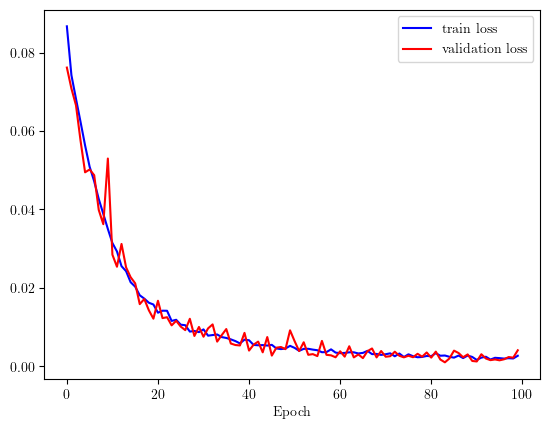

In [10]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

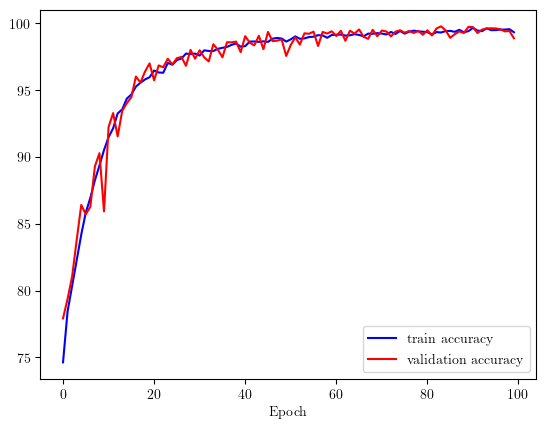

In [11]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [12]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.004639075277168058
Test accuracy:  98.89087903003582


## Compute and display traversal costs

In [13]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.siamese.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

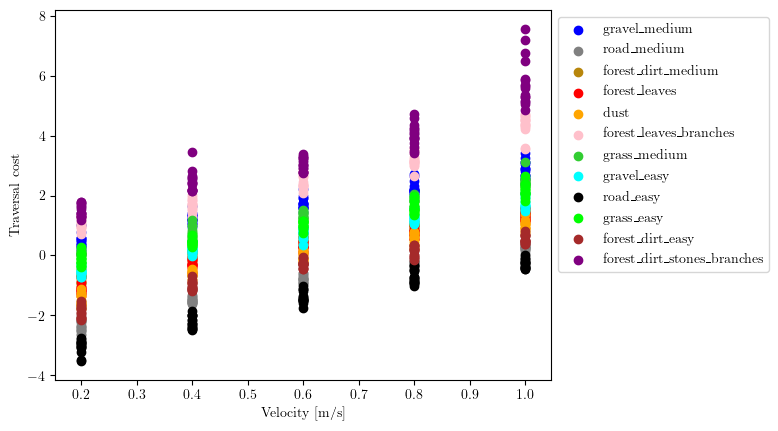

In [14]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

## Generate a log directory

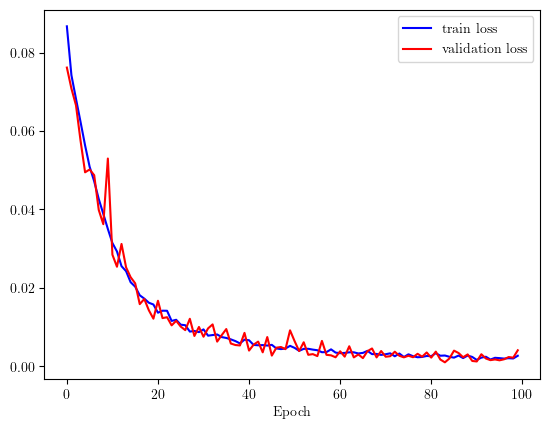

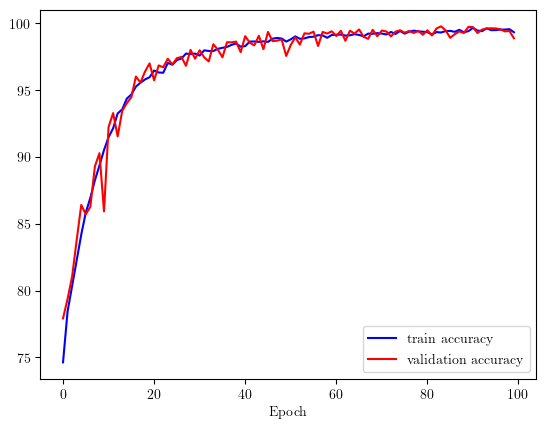

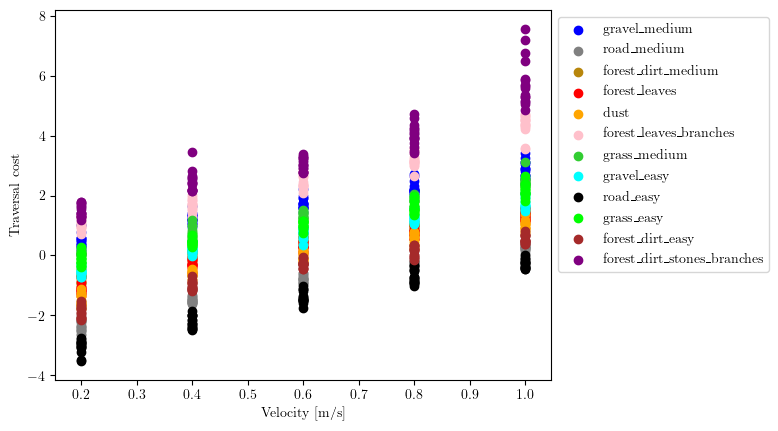

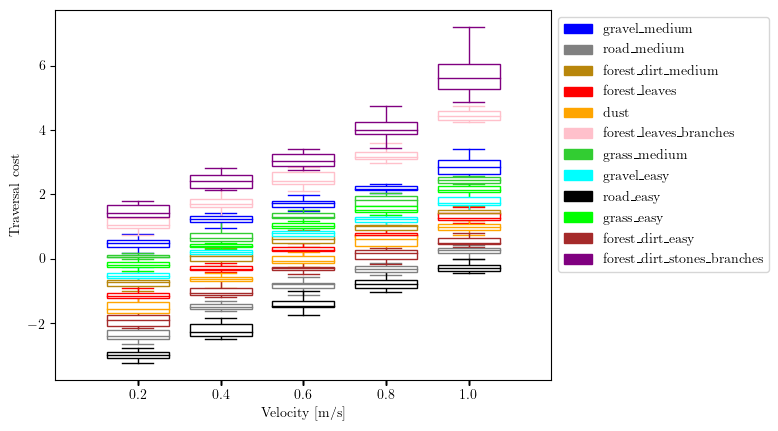

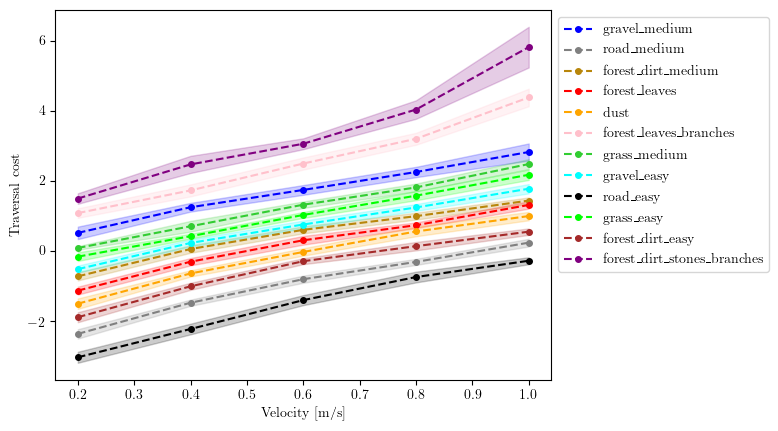

In [15]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = "logs/_" +\
                        params.siamese.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(dataset_directory=params.siamese.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)